The day024 CNN on MNIST data we used, compared to LeNet-5. But dropout and ReLU came out after the LeNet paper, we will still add dropout and using ReLU instead of Tanh in origin paper

| 特征      | LeNet-5            | 你的 TorchCNN        |
| ------- | ------------------ | ------------------ |
| 输入尺寸    | 32×32              | 28×28              |
| Conv1   | 6×(5×5) 无 padding  | 32×(3×3) padding=1 |
| Conv2   | 16×(5×5) 无 padding | 64×(3×3) padding=1 |
| 激活      | Sigmoid / Tanh     | ReLU               |
| 池化      | 平均池化               | 最大池化               |
| Dropout | 无                  | 有 (p=0.5)          |
| 全连接层    | 120 → 84 → 10      | 128 → 10           |
| 设计年代    | 1998               | 现代简化版 CNN          |


# 1. Imports & Utils

In [1]:
import os, time, math, random, numpy as np
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            pass #torch.mps follows torch.manual_seed
    except Exception:
        pass

    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except Exception:
        pass

In [19]:
def plot_curves(history_dict, title="Training curves", xlabel="Epoch"):
    plt.figure(figsize=(8,5))
    for k, v in history_dict.items():
        plt.plot(v, label=k)
    plt.xlabel(xlabel)
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
set_seed()

# 2. PyTorch LeNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"PyTorch using device: {device}")

PyTorch using device: mps


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds_full = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST("./data", train=False, download=True, transform=transform)

val_size = 10000
train_size = len(train_ds_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(train_ds_full, [train_size, val_size])

pin = (device.type in ["cuda", "mps"])
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=pin)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=pin)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=pin)

In [9]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, p_drop=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=0) #N * 1 * 28 * 28 -> N * 6 * 24 * 24
        self.pool1 = nn.AvgPool2d(2) #N * 6 * 24 * 24 -> N * 6 * 12 * 12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0) #N * 6 * 12 * 12 -> N * 16 * 8 * 8
        self.pool2 = nn.AvgPool2d(2) #N * 16 * 8 * 8 -> N * 16 * 4 * 4
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.drop = nn.Dropout(p_drop)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def evaluate_pt(model, loader, criterion):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            batch_size = xb.size(0)
            tot_loss += loss.item() * batch_size
            tot += batch_size
            pred = logits.argmax(1)
            tot_correct += (pred == yb).sum().item()
    return tot_loss / tot, tot_correct / tot

In [17]:
def train_lenet_pt(epochs=10, lr=1e-3, weight_decay=5e-4, patience=5):
    model = LeNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val = float("inf")
    best_state = None
    wait = 0

    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs + 1):
        model.train()
        t0 = time.time()
        train_loss_sum, train_correct,train_total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

            batch_size = xb.size(0)
            train_loss_sum += loss.item() * batch_size
            train_total += batch_size
            with torch.no_grad():
                pred = logits.argmax(1)
                train_correct += (pred == yb).sum().item()

        tr_loss = train_loss_sum / train_total
        tr_acc = train_correct / train_total
        val_loss, val_acc = evaluate_pt(model, val_loader, criterion)
    
        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
    
        print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} ({time.time()-t0:.1f}s)")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc = evaluate_pt(model, test_loader, criterion)
    print(f"PyTorch LeNet test: loss = {test_loss:.4f}, acc = {test_acc:.4f}")
    return model, hist

In [18]:
pt_model, pt_hist = train_lenet_pt(epochs=12, lr=1e-3, weight_decay=5e-4, patience=3)



Epoch 01 | train_loss=0.5560 train_acc=0.8244 | val_loss=0.1652 val_acc=0.9500 (9.4s)
Epoch 02 | train_loss=0.1827 train_acc=0.9459 | val_loss=0.1118 val_acc=0.9667 (4.7s)
Epoch 03 | train_loss=0.1342 train_acc=0.9603 | val_loss=0.0918 val_acc=0.9724 (4.7s)
Epoch 04 | train_loss=0.1110 train_acc=0.9662 | val_loss=0.0785 val_acc=0.9752 (4.7s)
Epoch 05 | train_loss=0.0969 train_acc=0.9720 | val_loss=0.0691 val_acc=0.9789 (4.7s)
Epoch 06 | train_loss=0.0846 train_acc=0.9751 | val_loss=0.0628 val_acc=0.9816 (4.8s)
Epoch 07 | train_loss=0.0778 train_acc=0.9767 | val_loss=0.0569 val_acc=0.9846 (4.7s)
Epoch 08 | train_loss=0.0715 train_acc=0.9792 | val_loss=0.0549 val_acc=0.9839 (4.7s)
Epoch 09 | train_loss=0.0630 train_acc=0.9808 | val_loss=0.0518 val_acc=0.9852 (4.7s)
Epoch 10 | train_loss=0.0625 train_acc=0.9810 | val_loss=0.0497 val_acc=0.9857 (4.7s)
Epoch 11 | train_loss=0.0590 train_acc=0.9818 | val_loss=0.0439 val_acc=0.9873 (4.7s)
Epoch 12 | train_loss=0.0551 train_acc=0.9831 | val_lo

NameError: name 'plot' is not defined

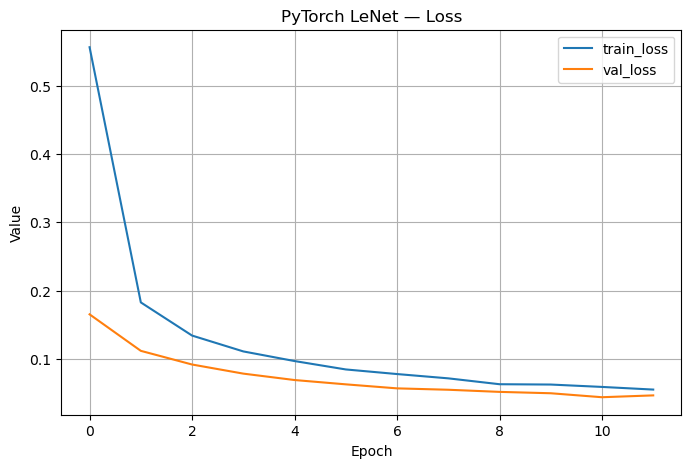

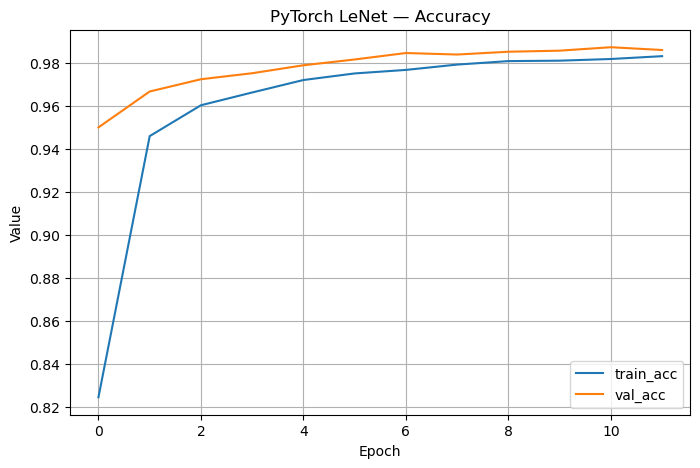

In [20]:
# Plot curves
plot_curves({"train_loss": pt_hist["train_loss"], "val_loss": pt_hist["val_loss"]}, "PyTorch LeNet — Loss")
plot_curves({"train_acc": pt_hist["train_acc"], "val_acc": pt_hist["val_acc"]}, "PyTorch LeNet — Accuracy")

# 3. Tensorflow LeNet

In [34]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

In [35]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32")/255.0)[..., None]
x_test  = (x_test.astype("float32") /255.0)[..., None]

In [36]:
val_split = 10000
x_val, y_val = x_train[-val_split:], y_train[-val_split:]
x_train, y_train = x_train[:-val_split], y_train[:-val_split]

In [37]:
l2 = keras.regularizers.l2(5e-4)

In [38]:
tf_model = keras.Sequential([
    layers.Conv2D(6, 5, padding="valid", activation="relu", kernel_regularizer=l2, input_shape=(28,28,1)),
    layers.AveragePooling2D(), #pool_size=(2, 2), strides=(2, 2) default
    layers.Conv2D(16, 5, padding="valid", activation="relu", kernel_regularizer=l2),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(120, activation="relu", kernel_regularizer=l2),
    layers.Dropout(0.5),
    layers.Dense(84, activation="relu", kernel_regularizer=l2),
    layers.Dense(10)
])

In [39]:
tf_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


In [41]:
tf_hist = tf_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/10
391/391 - 4s - loss: 0.6738 - accuracy: 0.8219 - val_loss: 0.2596 - val_accuracy: 0.9529 - 4s/epoch - 10ms/step
Epoch 2/10
391/391 - 4s - loss: 0.3160 - accuracy: 0.9385 - val_loss: 0.2131 - val_accuracy: 0.9672 - 4s/epoch - 10ms/step
Epoch 3/10
391/391 - 4s - loss: 0.2551 - accuracy: 0.9550 - val_loss: 0.1797 - val_accuracy: 0.9764 - 4s/epoch - 10ms/step
Epoch 4/10
391/391 - 4s - loss: 0.2205 - accuracy: 0.9637 - val_loss: 0.1679 - val_accuracy: 0.9769 - 4s/epoch - 10ms/step
Epoch 5/10
391/391 - 4s - loss: 0.1994 - accuracy: 0.9670 - val_loss: 0.1530 - val_accuracy: 0.9806 - 4s/epoch - 10ms/step
Epoch 6/10
391/391 - 4s - loss: 0.1858 - accuracy: 0.9701 - val_loss: 0.1395 - val_accuracy: 0.9833 - 4s/epoch - 10ms/step
Epoch 7/10
391/391 - 4s - loss: 0.1706 - accuracy: 0.9728 - val_loss: 0.1346 - val_accuracy: 0.9839 - 4s/epoch - 10ms/step
Epoch 8/10
391/391 - 4s - loss: 0.1615 - accuracy: 0.9744 - val_loss: 0.1302 - val_accuracy: 0.9855 - 4s/epoch - 10ms/step
Epoch 9/10
391/3

In [42]:
test_loss, test_acc = tf_model.evaluate(x_test, y_test, verbose=0)
print(f"TF LeNet Test: loss={test_loss:.4f}, acc={test_acc:.4f}")


TF LeNet Test: loss=0.1099, acc=0.9872


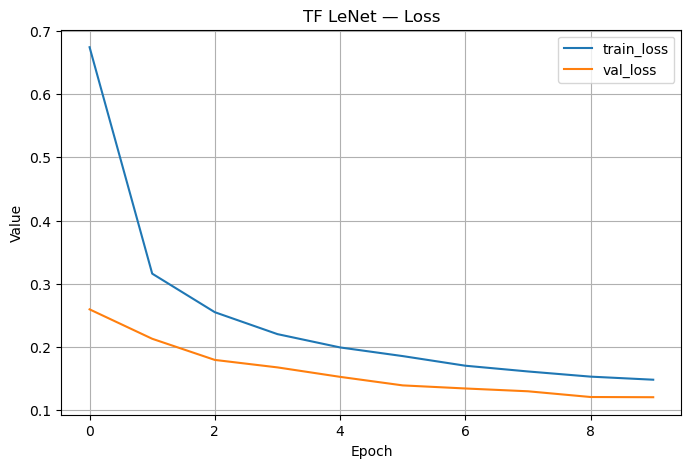

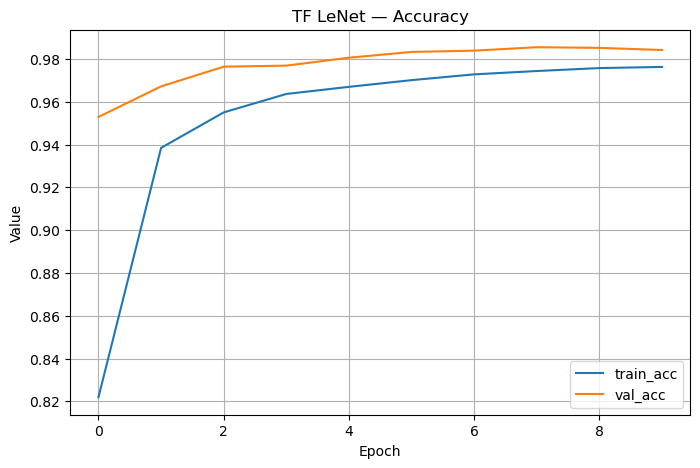

In [43]:
# Plot TF curves
history = tf_hist.history
plot_curves({"train_loss": history["loss"], "val_loss": history["val_loss"]}, "TF LeNet — Loss")
plot_curves({"train_acc": history["accuracy"], "val_acc": history["val_accuracy"]}, "TF LeNet — Accuracy")

# 4. Optimizers (SGD/Momentum/Adam) NumPy

In [44]:
class SGDOptimizer:
    def __init__(self, params, lr=1e-2):
        self.params = params
        self.lr = lr

    def step(self, grads):
        for k, g in grads.items():
            self.params[k] -= self.lr * g

In [45]:
class MomentumOptimizer:
    def __init__(self, params, lr=1e-2, beta=0.9):
        self.params = params
        self.lr = lr
        self.beta = beta
        self.v = {k: np.zeros_like(v) for k, v in params.items()}

    def step(self, grads):
        for k, g in grads.items():
            self.v[k] = self.beta * self.v[k] + (1 - self.beta) * g
            self.params[k] -= self.lr * self.v[k]

In [46]:
class RMSPropOptimizer:
    def __init__(self, params, lr=1e-2, rho=0.9, eps=1e-8, centered=False):
        self.params = params
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.centered = centered
        self.v = {k: np.zeros_like(v) for k, v in params.items()}
        self.m = {k: np.zeros_like(v) for k, v in params.items()}

    def step(self, grads):
        for k, g in grads.items():
            self.v[k] = self.rho * self.v[k] + (1.0 - self.rho) * (g * g)

            if self.centered:
                self.m[k] = self.rho * self.m[k] + (1.0 - self.rho) * g
                denom = np.sqrt(self.v[k] - self.m[k] * self.m[k] + self.eps)
            else:
                denom = np.sqrt(self.v[k] + self.eps)

            self.params[k] -= self.lr * g / denom

In [47]:
class AdamOptimizer:
    def __init__(self, params, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {k: np.zeros_like(v) for k, v in params.items()}
        self.v = {k: np.zeros_like(v) for k, v in params.items()}
        self.t = 0

    def step(self, grads):
        self.t += 1
        for k, g in grads.items():
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * g
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (g * g)
            m_hat = self.m[k] / (1 - self.beta1 ** self.t)
            v_hat = self.v[k] / (1 - self.beta2 ** self.t)
            self.params[k] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

### GPT code for MLP with the different optimizers:

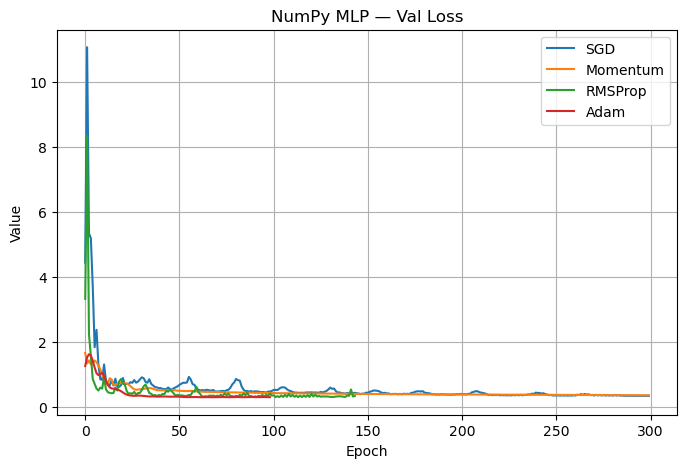

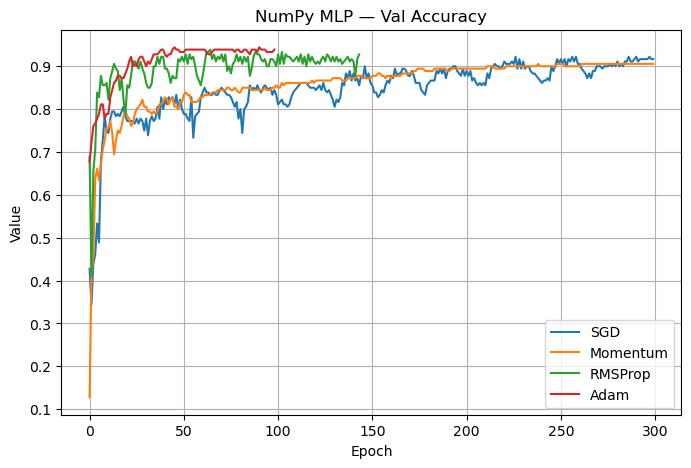

In [49]:
# Simple NumPy MLP for a 3-class toy dataset; train with different optimizers to compare.

def make_blobs(n_samples=900, n_features=2, centers=3, std=1.2, seed=42):
    rng = np.random.default_rng(seed)
    X, y = [], []
    per = n_samples // centers
    for c in range(centers):
        mean = rng.uniform(-5, 5, size=(n_features,))
        cov = (std**2) * np.eye(n_features)
        Xi = rng.multivariate_normal(mean, cov, size=per)
        yi = np.full((per,), c, dtype=int)
        X.append(Xi); y.append(yi)
    X = np.vstack(X); y = np.concatenate(y)
    idx = rng.permutation(len(X))
    return X[idx], y[idx]

def one_hot(y, C):
    Y = np.zeros((y.size, C))
    Y[np.arange(y.size), y] = 1
    return Y

class MLP:
    def __init__(self, in_dim, hidden, out_dim, keep_prob=1.0, l2=0.0, seed=42):
        rng = np.random.default_rng(seed)
        self.W1 = rng.standard_normal((in_dim, hidden)) * np.sqrt(2.0/in_dim)
        self.b1 = np.zeros((1, hidden))
        self.W2 = rng.standard_normal((hidden, out_dim)) * np.sqrt(2.0/hidden)
        self.b2 = np.zeros((1, out_dim))
        self.keep_prob = keep_prob
        self.l2 = l2
        self.training = True
        self._mask = None

    def forward(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = np.maximum(0, Z1)  # ReLU
        if self.training and self.keep_prob < 1.0:
            mask = (np.random.rand(*A1.shape) < self.keep_prob).astype(A1.dtype)
            A1 = A1 * mask / self.keep_prob
            self._mask = mask
        else:
            self._mask = None
        Z2 = A1 @ self.W2 + self.b2
        return Z1, A1, Z2

    def loss_and_grads(self, X, y):
        # forward
        Z1, A1, Z2 = self.forward(X)
        logits = Z2 - Z2.max(axis=1, keepdims=True)
        exp = np.exp(logits)
        probs = exp / exp.sum(axis=1, keepdims=True)
        N = X.shape[0]
        y1 = one_hot(y, probs.shape[1])
        data_loss = -np.sum(y1 * np.log(probs + 1e-9)) / N
        reg_loss  = 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2))
        loss = data_loss + reg_loss
        # grads
        dZ2 = (probs - y1) / N
        dW2 = A1.T @ dZ2 + self.l2 * self.W2
        db2 = dZ2.sum(axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        if self._mask is not None:
            dA1 = dA1 * self._mask / self.keep_prob
        dZ1 = dA1 * (Z1 > 0)
        dW1 = X.T @ dZ1 + self.l2 * self.W1
        db1 = dZ1.sum(axis=0, keepdims=True)
        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return loss, grads

    def params(self):
        return {"W1": self.W1, "b1": self.b1, "W2": self.W2, "b2": self.b2}

    def accuracy(self, X, y):
        self.training = False
        _, _, Z2 = self.forward(X)
        preds = Z2.argmax(axis=1)
        return (preds == y).mean()

def train_numpy_mlp(optimizer_cls, opt_kwargs, epochs=300, keep_prob=0.8, l2=1e-3, lr=None):
    X, y = make_blobs(n_samples=900, n_features=2, centers=3, std=1.2, seed=1)
    split = int(0.8 * len(X))
    X_tr, y_tr = X[:split], y[:split]
    X_va, y_va = X[split:], y[split:]

    mlp = MLP(in_dim=2, hidden=64, out_dim=3, keep_prob=keep_prob, l2=l2, seed=2)
    params = mlp.params()
    if lr is not None:
        opt_kwargs = {**opt_kwargs, "lr": lr}
    opt = optimizer_cls(params, **opt_kwargs)

    tr_losses, va_losses, tr_accs, va_accs = [], [], [], []
    best_va = float("inf")
    best_snapshot = None
    patience, wait = 30, 0

    for ep in range(1, epochs+1):
        mlp.training = True
        loss, grads = mlp.loss_and_grads(X_tr, y_tr)
        opt.step(grads)
        mlp.training = False
        val_loss, _ = mlp.loss_and_grads(X_va, y_va)

        tr_losses.append(loss)
        va_losses.append(val_loss)
        tr_accs.append(mlp.accuracy(X_tr, y_tr))
        va_accs.append(mlp.accuracy(X_va, y_va))

        if val_loss < best_va:
            best_va = val_loss
            best_snapshot = {k: v.copy() for k,v in params.items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                # early stop
                break

    if best_snapshot is not None:
        for k,v in best_snapshot.items():
            params[k][...] = v

    return {"train_loss": tr_losses, "val_loss": va_losses,
            "train_acc": tr_accs, "val_acc": va_accs}

# Run comparisons
hist_sgd      = train_numpy_mlp(SGDOptimizer,      {"lr":1e-1},   epochs=300, keep_prob=0.8, l2=1e-3)
hist_momentum = train_numpy_mlp(MomentumOptimizer, {"lr":8e-2, "beta":0.9}, epochs=300, keep_prob=0.8, l2=1e-3)
hist_rmsprop = train_numpy_mlp(RMSPropOptimizer, {"lr":5e-2, "rho":0.9}, epochs=300, keep_prob=0.8, l2=1e-3)
hist_adam     = train_numpy_mlp(AdamOptimizer,     {"lr":5e-2},   epochs=300, keep_prob=0.8, l2=1e-3)

# Plot comparison
plot_curves({"SGD": hist_sgd["val_loss"],
             "Momentum": hist_momentum["val_loss"],
             "RMSProp": hist_rmsprop["val_loss"],
             "Adam": hist_adam["val_loss"]}, "NumPy MLP — Val Loss")

plot_curves({"SGD": hist_sgd["val_acc"],
             "Momentum": hist_momentum["val_acc"],
             "RMSProp": hist_rmsprop["val_acc"],
             "Adam": hist_adam["val_acc"]}, "NumPy MLP — Val Accuracy")


### logistic regression with those optimizers (in order to plot the optimizer trajectories)
之所以用 logistic regression，是因为 MLP 的参数维度很高，无法直接画 2D 等高线。这里固定 b 来近似可视化损失地形。

In [50]:
def make_binary_blobs(n_samples=600, std=1.2, seed=42):
    rng = np.random.default_rng(seed)
    n = n_samples // 2
    mean0, mean1 = np.array([-3.0, -3.0]), np.array([3.0, 3.0])
    cov = (std ** 2) * np.eye(2)
    X0 = rng.multivariate_normal(mean0, cov, size=n)
    X1 = rng.multivariate_normal(mean1, cov, size=n)
    X = np.vstack([X0, X1])
    y = np.concatenate([np.zeros(n, dtype=int), np.ones(n, dtype=int)])
    idx = rng.permutation(len(X))
    return X[idx], y[idx]

In [51]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [52]:
def bce_loss(p, y):
    eps = 1e-9
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

In [69]:
def train_logreg_paths(optimizers_cls, opt_kwargs, X, y, steps=200):
    #params: w in R^{2x1}, b scaler
    y = y.reshape(-1, 1)
    rng = np.random.default_rng(42)
    params = {
        "w": rng.standard_normal((2, 1)) * 0.5,
        "b": np.array([0.0], dtype=float)
    }
    opt = optimizers_cls(params, **opt_kwargs)
    w_path, losses = [], []
    N = X.shape[0]

    for t in range(steps):
        #forward
        z = X @ params["w"] + params["b"]
        p = sigmoid(z)
        loss = bce_loss(p, y)
        losses.append(loss)

        #grads:
        dz = (p - y) / N
        dw = X.T @ dz
        db = np.sum(dz, axis=0)
        grads = {"w": dw, "b": db}

        w_path.append(params["w"].ravel().copy())

        #step
        opt.step(grads)

    #last forward to get loss 
    z = X @ params["w"] + params["b"]
    p = sigmoid(z)
    final_loss = bce_loss(p, y)
    return np.array(w_path), np.array(losses), params, final_loss

In [70]:
Xb, yb = make_binary_blobs(800, 1.3, 3)

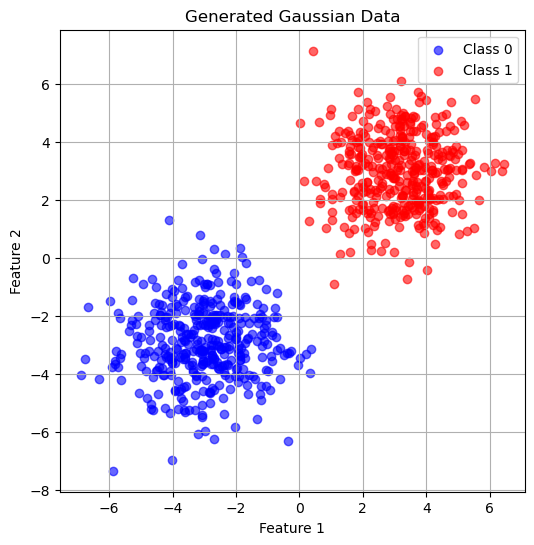

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(Xb[yb==0, 0], Xb[yb==0, 1], color='blue', alpha=0.6, label='Class 0')
plt.scatter(Xb[yb==1, 0], Xb[yb==1, 1], color='red', alpha=0.6, label='Class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Gaussian Data")
plt.legend()
plt.grid(True)
plt.show()

In [72]:
paths = {}
finals = []

In [73]:
paths["SGD"], loss_sgd, p_sgd, f_sgd = train_logreg_paths(SGDOptimizer,      {"lr": 5e-2}, Xb, yb, steps=250)
paths["Momentum"], loss_mom, p_mom, f_mom = train_logreg_paths(MomentumOptimizer, {"lr": 6e-2, "beta":0.9}, Xb, yb, steps=250)
paths["RMSProp"], loss_rms, p_rms, f_rms = train_logreg_paths(RMSPropOptimizer, {"lr": 1e-2, "rho":0.9}, Xb, yb, steps=250)
paths["Adam"], loss_adam, p_adam, f_adam = train_logreg_paths(AdamOptimizer, {"lr": 8e-3}, Xb, yb, steps=250)

In [74]:
finals = []
for name, (losses, params) in {
    "SGD": (loss_sgd, p_sgd),
    "Momentum": (loss_mom, p_mom),
    "Adam": (loss_adam, p_adam),
    **({"RMSProp": (loss_rms, p_rms)} if "loss_rms" in locals() else {})
}.items():
    z = Xb @ params["w"] + params["b"]
    finals.append((bce_loss(sigmoid(z), yb.reshape(-1,1)), name, params))
best_loss, best_name, best_params = min(finals, key=lambda t: t[0])
b_fixed = float(best_params["b"][0])

In [77]:
#build loss surface grid over (w1, w2) with b fixed
all_ws = np.vstack([p for p in paths.values()])
w1_min, w1_max = all_ws[:,0].min()-1.0, all_ws[:,0].max()+1.0
w2_min, w2_max = all_ws[:,1].min()-1.0, all_ws[:,1].max()+1.0

W1, W2 = np.meshgrid(np.linspace(w1_min, w1_max, 200), np.linspace(w2_min, w2_max, 200))
L = np.zeros_like(W1)
X_aug = Xb  # (N,2)
Yv = yb.reshape(-1,1)

for i in range(W1.shape[0]):
    w_batch = np.stack([W1[i].ravel(), W2[i].ravel()], axis=1)  # (M,2)
    # compute loss for each point with same b
    Z = X_aug @ w_batch.T + b_fixed   # (N, M)
    P = 1.0 / (1.0 + np.exp(-Z))
    # average BCE over samples, then reshape back to grid row
    eps = 1e-9
    L_row = -np.mean(Yv * np.log(P + eps) + (1 - Yv) * np.log(1 - P + eps), axis=0)
    L[i] = L_row.reshape(W1.shape[1])

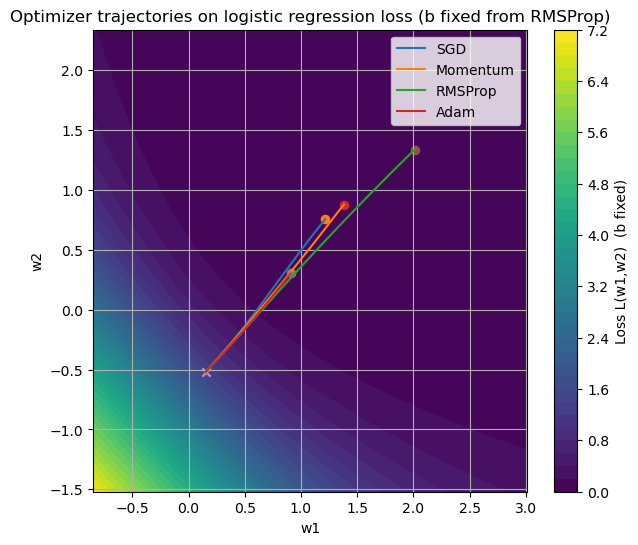

In [78]:
#plot contour and paths
plt.figure(figsize=(7,6))
cs = plt.contourf(W1, W2, L, levels=40)
plt.colorbar(cs, label="Loss L(w1,w2)  (b fixed)")
for name, path in paths.items():
    plt.plot(path[:,0], path[:,1], label=name)
    plt.scatter(path[0,0], path[0,1], s=35, marker="x")   # start
    plt.scatter(path[-1,0], path[-1,1], s=35, marker="o") # end
plt.title(f"Optimizer trajectories on logistic regression loss (b fixed from {best_name})")
plt.xlabel("w1"); plt.ylabel("w2"); plt.legend(); plt.grid(True)
plt.show()